In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl

from netCDF4 import num2date
import numpy as np
import glob
import pytz
import SNmods as snmods
import probe_info
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind
from scipy import interpolate
import matplotlib.cm as cm

import pandas as pd
import DataPull

In [6]:
def plot_meteogram(ws, wd, tempf, dewpf, rh, meanslp, thetae, thetav, id_probe, target_date, save_dir=None):
    
    
    
    # set up fontsizes 
    plt.rc('xtick',labelsize=14)
    plt.rc('ytick',labelsize=14)
    # set up figure
    fig = plt.figure(figsize = (16,20))
    top_anchor = 1.3 # changes title/legend relation to their plot
    lfs = 16 # legend fontsize
    ylfs = 15 # ylable fontsize


    # plot wind direction and speed
    ax1 = fig.add_subplot(611)
    times = ws.index
    plt.gca().xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H:%M UTC'))
    dates = mpl.dates.date2num(times.to_pydatetime())
    ln1 = ax1.plot(dates,ws,label='Wind Speed')
    plt.ylim(0,max(ws)+2)
    plt.fill_between(dates,ws,plt.ylim()[0],color = 'C0',alpha = 0.8)
    plt.ylabel('Wind Speed\n(knots)', multialignment='center',fontsize = ylfs)
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    ax5 = ax1.twinx()
    ln3 = ax5.plot(dates,wd,'.k', alpha = 0.8, markersize=3, label='Wind Direction')
    plt.ylim(0,360)
    plt.ylabel('Wind Direction\n(degrees)', multialignment='center',fontsize = ylfs)
    plt.yticks(np.arange(45,405,90),['NE','SE','SW','NW'])
    lns = ln1+ln3 
    labs = [l.get_label() for l in lns]
    ax5.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5,top_anchor),ncol=2,prop={'size':lfs})

    # plot temp and dewpoint
    ax3 = fig.add_subplot(612, sharex=ax1)
    ymax,ymin = (max(tempf)+2,min(dewpf)-2)
    ax3.set_ylim(ymin,ymax)
    plt.ylabel('Temperature\n(F)', multialignment='center',fontsize = ylfs)
    plt.fill_between(dates,tempf,dewpf,color = '#D60B0B',alpha = 0.8, label = 'Temperature') #'#A32714'
    plt.fill_between(dates,dewpf,plt.ylim()[0],color = 'darkgreen', alpha = 0.8,label = 'Dewpoint') #'#45995A'
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    ax3.legend(loc='upper center', bbox_to_anchor=(0.5,top_anchor),ncol=2,prop={'size':lfs})
    axtwin = ax3.twinx()
    axtwin.set_ylim(ymin,ymax)

    # Relative Humidity    
    ax6 = fig.add_subplot(613, sharex=ax1)
    ax6.set_ylim(0,100,4)
    plt.fill_between(dates,rh,plt.ylim()[0],color= '#519E11',alpha = 0.6,label='Relative Humidity')#'#51A80A'
    ax6.legend(loc='upper center',bbox_to_anchor=(0.5,top_anchor),prop={'size':lfs})
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    plt.ylabel('Relative Humidity\n(%)',multialignment='center',fontsize = ylfs)
    axtwin = ax6.twinx()
    axtwin.set_ylim(0,100,4)

    # MSLP
    ax7 = fig.add_subplot(614, sharex=ax1)
    #ax7.plot(dates,meanslp,'m',)
    ymax = np.round(np.max(meanslp))+1
    ymin = np.round(np.min(meanslp))-1
    plt.ylim(ymin,ymax)
    plt.ylabel('Mean Sea\nLevel Pressure\n(mb)', multialignment='center',fontsize = ylfs)
    plt.fill_between(dates,meanslp,plt.ylim()[0],color = '#E37609',alpha = 0.8,label='Mean Sea Level Pressure')
    ax7.legend(loc='upper center',bbox_to_anchor=(0.5,top_anchor),prop={'size':lfs})
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    axtwin = ax7.twinx()
    axtwin.set_ylim(ymin,ymax)

    # plot theta_e
    ax4 = fig.add_subplot(615, sharex = ax1)
    ymax,ymin = (max(thetae)+2,min(thetae)-2)
    ax4.set_ylim(ymin,ymax)
    #ax4.plot(dates,thetae)
    plt.fill_between(dates,thetae,plt.ylim()[0], color = 'darkcyan',alpha = 0.8, label = "Theta E")
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    ax4.legend(loc='upper center', bbox_to_anchor=(0.5,top_anchor),ncol=2,prop={'size':lfs})
    plt.ylabel('Temperature\n(K)', multialignment='center',fontsize = ylfs)
    axtwin = ax4.twinx()
    axtwin.set_ylim(ymin,ymax)

    # plot theta v
    ax2 = fig.add_subplot(616, sharex=ax1)
    ymax,ymin = (max(thetav)+2,min(thetav)-2)
    ax2.set_ylim(ymin,ymax)
    #ax2.plot(dates,thetav)
    plt.fill_between(dates,thetav,plt.ylim()[0], color = 'darkslateblue',alpha = 0.8,label = 'Theta V')
    plt.grid(b=True,which='major',axis='y',color='k',linestyle='--',linewidth=0.5)
    #ax2.set_title('Theta v')
    plt.ylabel('Temperature\n(K)', multialignment='center',fontsize = ylfs)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5,top_anchor),ncol=2,prop={'size':lfs})
    axtwin = ax2.twinx()
    axtwin.set_ylim(ymin,ymax)

    # edits to whole figure               
    plt.suptitle('Date: '+target_date.strftime('%D')+', '+times[0].strftime('%H%M')+' - '+times[-1].strftime('%H%M UTC')+
                 '\n Probe ID: '+id_probe, fontsize = 22, y = .94)
    fig.subplots_adjust(hspace=0.5)
    plt.gca().set_xlim(dates.min(),dates.max()) # automatically removes any white buffer space on edges of plots
    mpl.rc('ytick',labelsize = 12)
    mpl.rc('xtick',labelsize = 14)
    
    if save_dir:
         plt.savefig('{0}/FILENAME.png'.format(save_dir),dpi=300,bbox_inches = 'tight')
         plt.close()
        
    plt.show()

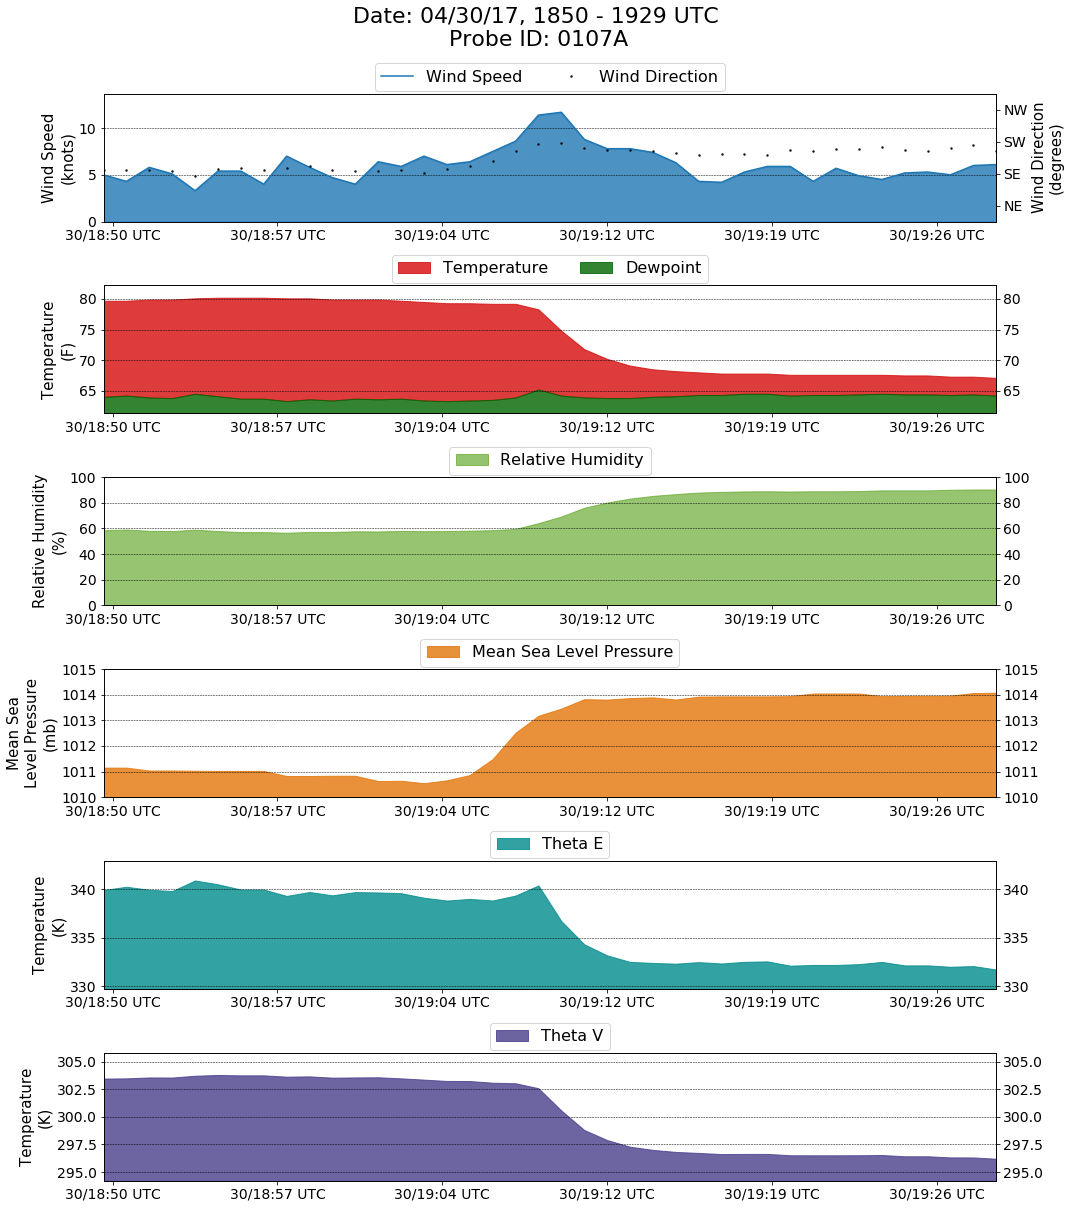

In [7]:
###### USER EDIT ######

target_date = dt.datetime(2017,4,30)
starttime=dt.datetime(2017,4,30,18,50)
duration = 40 # minutes
probe_id = '0107A'

# File directory where the realtime text files are located
directory = r'/Users/jessmcd/Documents/MyPassport_backup/VSE_Data/{}/{}/'.format(
    target_date.strftime('%Y'), target_date.strftime('%Y%m%d'))

# save_fig = directory you want to save a figure in - OPTIONAL

######################

# pull data
data_df, elevation, lat, lon = DataPull.get_data(probe_id, starttime, duration, directory)

# make calculations
temp_f = C_to_F(data_df['T'])
dewp   = calc_dewpoint(data_df['T'],data_df['RH'])
dewp_f = C_to_F(dewp)
thetae = calc_thetae(data_df['T'], dewp, data_df['P'])
thetav = calc_thetav(data_df['T'], dewp, data_df['P'])
mslp = calc_mslp(data_df['T'],data_df['P'], elevation)

# plot!
plot_meteogram(data_df['WS'], data_df['WD'], temp_f, dewp_f, data_df['RH'], mslp, thetae, thetav,
              probe_id, target_date )

In [3]:
import SNmods as snmods

target_date = dt.datetime(2017,4,30,)
starttime=dt.datetime(2017,4,30)
duration = 60*23 # minutes

endtime=starttime+dt.timedelta(minutes=duration)

probes = [6]

# File directory where the realtime text files are located
filedir = r'/Users/jessmcd/Documents/MyPassport_backup/VSE_Data/{}/{}/'.format(
    target_date.strftime('%Y'), target_date.strftime('%Y%m%d'))

p=snmods.search_dir(filedir, starttime, endtime, dataset='full', probes=[6]);

0106A


In [170]:
import SNobject as sn
probe_locs = probe_info.probe_locs_2017
###### USER EDIT ######

target_date = dt.datetime(2017,4,30,)
starttime=dt.datetime(2017,4,30)
duration = 60*23 # minutes
probes = [6]

# File directory where the realtime text files are located
filedir = r'/Users/jessmcd/Documents/MyPassport_backup/VSE_Data/{}/{}/'.format(
    target_date.strftime('%Y'), target_date.strftime('%Y%m%d'))

dataset='full'
endtime=starttime+dt.timedelta(minutes=duration)

# save_fig = directory you want to save a figure in - OPTIONAL

######################

# pull data
#data_df, elevation, lat, lon = DataPull.get_data(probe_id, starttime, duration, directory)

# the plot meteogram goes inside of the Snmods.py script, I have pulled out the relevant code from there
# for testing. The plot_meteogram func should get (met, elevation, starttime, endttime, probe_id)

vars = {'LATS':1,
        'LONS':2,
        'T':5,
        'RH':6,
        'P':7,
        'WS':8,
        'WSMAX':9,
        'WD':10,
        'BATT':11}

# Create a string of times, one string per minute, over the specified time period
days = np.array([starttime+dt.timedelta(days=i) for i in range((endtime-starttime).days+1)])
days_string = np.array([i.strftime("%Y%m%d") for i in days])

for i in probes:
        # format the probe_id number
        if i > 12:
            probe_id = "02{0}A".format("%02d"%i)
        else:
            probe_id = "01{0}A".format("%02d"%i)
        print(probe_id)
        # Each realtime SN file is one line of text, containing the temporal averages of variables defined in
        # the configure file. Grab all the realtime files corresponding to the SN number in the 
        # file directory.
        if dataset == 'full':
            files = []
            for strings in days_string:
                files.extend(glob.glob(filedir+probe_id+'_'+strings+'_*.txt'))

            latest = ''
            if files: # not empty 

                date,pres,temp,ws,wd,rh,wsmax,batt = [],[],[],[],[],[],[],[]
                for f in files:
                    sn_data = sn.SNFile(f)
                    line = sn_data.read_realtime()
                    date.append(sn_data.datetime)
                    pres.append(float(line[vars['P']]))     # in hPa
                    temp.append(float(line[vars['T']]))     # in deg C
                    ws.append(float(line[vars['WS']]))      # in m/s
                    wd.append(float(line[vars['WD']]))      # in degrees
                    rh.append(float(line[vars['RH']]))      # in %
                    wsmax.append(float(line[vars['WSMAX']]))# in m/s
                    batt.append(float(line[vars['BATT']]))  # in Volts

                # organize data into a pandas dataframe object with -999.9 missing data replaced with NaNs
                d = {'P':pres,'T':temp,'RH':rh,'WS':ws,'WD':wd,'WSMAX':wsmax,'BATT':batt}
                met = pd.DataFrame(data=d,index=date).replace(-999.9,np.nan) 
                met.sort_index(inplace=True, ascending=True)
                #met = met[22*60:]
                elevation = int(probe_locs[probe_id][2])
                plot_meteogram(met,elevation,probe_id)            


#data_df = snmods.search_dir(directory, starttime, starttime+dt.timedelta(minutes=duration))

0106A


In [169]:



def plot_meteogram(met, elevation, probe_id):
    ''' 
    Plots the meteogram of a single sticknet. Accepts any length of time,
    but is designed to look best for 24 hour periods. 
    -----------
    Inputs:
    met       - a pandas dictionary containing Temp ['T'], RH ['RH'], Pressure ['P'],
                windspeed ['WS'], 3 second wind gust ['WSMAX'], and wind dir ['WD'] 
                for a single StickNet.
    elevation - the elevation in meters of the Sticknet. Used to calculated 
                MSLP, ThetaE, and ThetaV
    probe_id  - 4 letter/number station identifier.
    -----------
    outputs: N/A. Saves meteogram to hardcoded location. Edit this for post-processing.  

    Upgraded J. McDonald 2021. 
    '''

    # pull and format data
    tempf     = C_to_F(met['T'])
    dewp      = calc_dewpoint(met['T'].values,met['RH'].values)
    dewpf     = C_to_F(dewp)
    thetae    = calc_thetae(met['T'].values, dewp, met['P'].values)
    thetav    = calc_thetav(met['T'].values, dewp, met['P'].values)
    mslp      = calc_mslp(met['T'].values,met['P'].values, elevation)
    dates     = pd.to_datetime(met.index)
    ws        = met['WS']
    ws3sec    = met['WSMAX']
    wd        = met['WD']
    RH        = met['RH']


    # set up fontsizes 
    plt.rc('xtick',labelsize=11)
    plt.rc('ytick',labelsize=13)
    
    # set up figure
    fig, axes = plt.subplots(5, figsize = (12,18))
    top_anchor = 1.15 # changes title/legend relation to their plot
    lfs = 13 # legend fontsize
    ylfs = 14 # ylable fontsize
    ec = '0.5' # color of legend outline. default is 0.8


    # plot wind direction and speed

    axes[0].set_ylim(0,max(ws3sec)+2)
    axes[0].plot(dates,ws,color='#57858c',alpha = 0.5, linewidth=1)
    ln1 = axes[0].fill_between(dates,ws,plt.ylim()[0],color='#57858c',alpha = 0.5,label='Wind Speed')
    ln2 = axes[0].scatter(dates, ws3sec, marker='s', color = '#655978', 
                          s=1.2, alpha=0.5, label='3-sec Gust', zorder=0)
    axes[0].set_ylabel('Wind Speed\n(knots)', multialignment='center',fontsize = ylfs)

    ax0 = axes[0].twinx()
    ln3 = ax0.plot(dates,wd,'.k', alpha = 0.8, markersize=3, label='Wind Direction')
    ax0.set_ylim(0,360)
    ax0.set_ylabel('Wind Direction\n(degrees)', multialignment='center',fontsize=ylfs)
    ax0.set_yticks(np.arange(45,405,90))
    ax0.set_yticklabels(['NE','SE','SW','NW'])

    lns = [ln1,ln2,ln3[0]] 
    labs = [l.get_label() for l in lns]
    ax0.legend(lns, labs, loc='upper left', markerscale=5,
               bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)


    # plot temp and dewpoint and RH

    ymax,ymin = (max(tempf)+3,min(dewpf)-3)
    axes[1].set_ylim(ymin,ymax)
    axes[1].set_ylabel('Temperature\n(F)', multialignment='center',fontsize = ylfs)
    ln1=axes[1].fill_between(dates,tempf,dewpf,color = '#a83939',alpha = 0.6, label = 'Temperature') 
    ln2=axes[1].fill_between(dates,dewpf,plt.ylim()[0],color = '#207849', alpha = 0.7,label = 'Dewpoint')

    ax1 = axes[1].twinx()
    ln3 = ax1.plot(dates,RH,color='#2b0000', linewidth=3,alpha=0.7, label='Relative Humidity')
    ax1.set_ylim(0,103)
    ax1.set_ylabel('Relative Humidity\n(%)',multialignment='center',fontsize = ylfs)
    lns = [ln1,ln2, ln3[0]] 
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper left', 
               bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)


    # MSLP

    axes[2].plot(dates,mslp,color = '#E37609',linewidth=3,alpha = 0.8,label='Mean Sea Level Pressure')
    ymax,ymin = np.round(np.max(mslp))+1,np.round(np.min(mslp))-1
    axes[2].set_ylim(ymin,ymax)
    axes[2].set_ylabel('Mean Sea Level\nPressure (mb)', multialignment='center',fontsize = ylfs)
    axes[2].legend(loc='upper left', bbox_to_anchor=(0.005,top_anchor),ncol=1,prop={'size':lfs},framealpha=1,
                  edgecolor=ec)


    # plot theta_v and theta_e

    ymax,ymin = (max(thetav)+2,min(thetav)-2)
    axes[3].set_ylim(ymin,ymax)
    ln1=axes[3].plot(dates,thetav, color = '#084b69',alpha = 0.7, linewidth=4,
                     label = r"${\theta_v}$")
    axes[3].set_ylabel(r'${\theta_v}$ (K)', multialignment='center',fontsize = ylfs)

    ax3 = axes[3].twinx()
    ymax,ymin = (max(thetae)+2,min(thetae)-2)
    ax3.set_ylim(ymin,ymax)
    ln2=ax3.plot(dates,thetae, color = '#508a50',alpha = 0.6,linewidth=3,
                 label = r"${\theta_e}$")
    ax3.set_ylabel(r'${\theta_e}$ (K)', multialignment='center',fontsize = ylfs)
    lns= [ln1[0],ln2[0]]
    labs=[l.get_label() for l in lns]
    ax3.legend(lns,labs,loc='upper left', bbox_to_anchor=(0.005,top_anchor),
               ncol=3,prop={'size':lfs},framealpha=1,edgecolor=ec)

    # theta_v gradient

    gradient = thetav[1:] - thetav[0:-1]

    axes[4].plot(dates[1:], gradient, color='#204e63',alpha=0.9,label=r"1-min ${\Delta\theta_v}$")
    axes[4].set_ylim(gradient.min()-1, gradient.max()+1)
    axes[4].set_ylabel(r'${\Delta\theta_v}$ (K/min)', multialignment='center',fontsize = ylfs)
    axes[4].legend(loc='upper left', bbox_to_anchor=(0.005,top_anchor),ncol=3,prop={'size':lfs},framealpha=1,
                  edgecolor=ec)
    axes[4].text(0.02, 0.1, 'Largest Decrease: {} K/min at {}'.format(np.round(min(gradient),2),
                dates[np.argmin(gradient)+1].strftime('%d/%H:%M UTC')), fontsize=14, color ='#204e63',
                 transform=axes[4].transAxes)

    #28264d the pretty purple color
    
    # number of hours rounded up
    length = np.ceil(((dates[-1]-dates[0]).seconds)/(60*60))

    for ax in axes.flatten():
        
        # assign proper date formatting based on number of hours plotted
        if length > 8:
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H UTC'))
        else:
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d/%H%M UTC'))
            
        # set grids and things
        ax.grid(color='k', linestyle=':', linewidth=0.3, alpha=0.7)
        ax.set_xlim(dates.min(),dates.max()) # removes white space buffer

    # title              
    plt.suptitle('{}-Hour Meteogram for Station {}'.format(int(length), probe_id), fontsize = 18, 
                  x=0.135, y = .94, weight='bold', ha='left')
    axes[0].set_title('Latest Observation: {}'.format(dates[-1].strftime('%D %H:%M UTC')),
                      ha='left',x=0.015, y=1.21, fontsize=16)
    fig.subplots_adjust(hspace=0.35)


    # Plot the TTU logo
    im = plt.imread("TTU_Logo.tif")
    newax = fig.add_axes([0.04,0.87,0.07,0.07],anchor='NW',zorder=10)
    newax.imshow(im, alpha=0.4)
    newax.axis('off')

    #     plt.savefig('{0}/FILENAME.png'.format(save_dir),dpi=300,bbox_inches = 'tight')
    #     plt.close()
    
    savedir = 'RT_tests' # hard coded real time directory
    obtime = parse_currtime()[1] # note that this may be different from last time on plot
                              # THATS OKAY... it will make data drops more apparent!
    plt.savefig('{0}/{1}_meteogram_{2}.png'.format(savedir,probe_id,obtime),dpi=300,bbox_inches = 'tight')
    plt.close()

    #plt.show()


In [163]:
def parse_currtime():
    """ parse the current datetime, in datetime format, to a specific string format for titles """
    currtime = dt.datetime.utcnow()
    #year = currtime.strftime("%Y")
    #month = currtime.strftime("%m")
    #day = currtime.strftime("%d")
    #hour = currtime.strftime("%H")
    #min = currtime.strftime("%M")
    #return "{0}-{1}-{2} {3}:{4} UTC".format(year,month,day,hour,min),currtime.strftime("%Y%m%d%H%M")
    return currtime.strftime("%Y-%m-%d %H:%M UTC"),currtime.strftime("%Y%m%d_%H%M")

In [164]:
parse_currtime()

('2021-01-18 19:20 UTC', '20210118_1920')